# Fdem Data Point Class

## Fdem Data contains entire data sets
## Fdem Data Points can forward model and evaluate themselves

### FdemData is an extension to the [Data](Data.ipynb) Class

##### Back to [Main](../../PackageInfo.ipynb)

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

from os.path import join
import numpy as np
import h5py
import matplotlib.pyplot as plt
from geobipy import hdfRead
from geobipy import FdemData
from geobipy import FdemDataPoint
from geobipy import Model1D
from geobipy import StatArray

In [2]:
# The data file name
dataFile = join('supplementary','Data','Resolve2.txt')
# The EM system file name
systemFile = join('supplementary','Data','FdemSystem2.stm')

## Initialize and read an EM data set

In [3]:
D = FdemData()
D.read(dataFile,systemFile)

## Summarize the Data

In [4]:
print(D.__doc__)

Class extension to geobipy.Data defining a Fourier domain electro magnetic data set
    
    FdemData(nPoints, nFrequencies, system)

    Parameters
    ----------
    nPoints : int, optional
        Number of observations in the data set
    nFrequencies : int, optional
        Number of measurement frequencies
    system : str or geobipy.FdemSystem, optional
        * If str: Must be a file name from which to read FD system information.
        * If FdemSystem: A deepcopy is made.

    Returns
    -------
    out : FdemData
        Contains x, y, z, elevation, and data values for a frequency domain dataset.

    Notes
    -----
    FdemData.read() requires a data filename and a system class or system filename to be specified.
    The data file is structured using columns with the first line containing header information.
    The header should contain the following entries
    Line [ID or FID] [X or N or northing] [Y or E or easting] [Z or DTM or dem_elev] [Alt or Laser or bheight] [I

In [5]:
D.summary()

3D Point Cloud: 
Number of Points: : 71470 
 Name:  Easting
    Units: m
    Shape: (71470,)
   Values: [586852.29 586852.23 586852.17 ... 590160.46 590163.5  590166.53]
No attached prior 
No attached proposal 
 Name:  Northing
    Units: m
    Shape: (71470,)
   Values: [4639119.38 4639122.68 4639125.98 ... 4640082.67 4640082.8  4640082.93]
No attached prior 
No attached proposal 
 Name:  Height
    Units: m
    Shape: (71470,)
   Values: [36.629 37.012 37.349 ... 33.123 33.021 32.917]
No attached prior 
No attached proposal 
Data:          : 
# of Channels: 12 
# of Total Data: 857640 



## Grab a measurement from the data set

FdemSystem: 
supplementary/Data/FdemSystem2.stm 
Name:  Frequencies
    Units: Hz
    Shape: (6,)
   Values: [   380.   1776.   3345.   8171.  41020. 129550.]
No attached prior 
No attached proposal 
 

Data Point: 
Channel Names ['In-Phase 380.0 (Hz)', 'In-Phase 1776.0 (Hz)', 'In-Phase 3345.0 (Hz)', 'In-Phase 8171.0 (Hz)', 'In-Phase 41020.0 (Hz)', 'In-Phase 129550.0 (Hz)', 'Quadrature 380.0 (Hz)', 'Quadrature 1776.0 (Hz)', 'Quadrature 3345.0 (Hz)', 'Quadrature 8171.0 (Hz)', 'Quadrature 41020.0 (Hz)', 'Quadrature 129550.0 (Hz)'] 
x: [586852.29] 
y: [4639119.38] 
z: [36.629] 
elevation: [1246.84] 
Number of active channels: 12 
Name:  Frequency domain data
    Units: ppm
    Shape: (12,)
   Values: [145.3 435.8 260.6 ... 516.5 405.7 255.7]
No attached prior 
No attached proposal 
 Name:  Predicted Data
    Units: ppm
    Shape: (12,)
   Values: [0. 0. 0. ... 0. 0. 0.]
No attached prior 
No attached proposal 
 Name:  Standard Deviation
    Units: ppm
    Shape: (12,)
   Values: [14.53 43

<IPython.core.display.Javascript object>


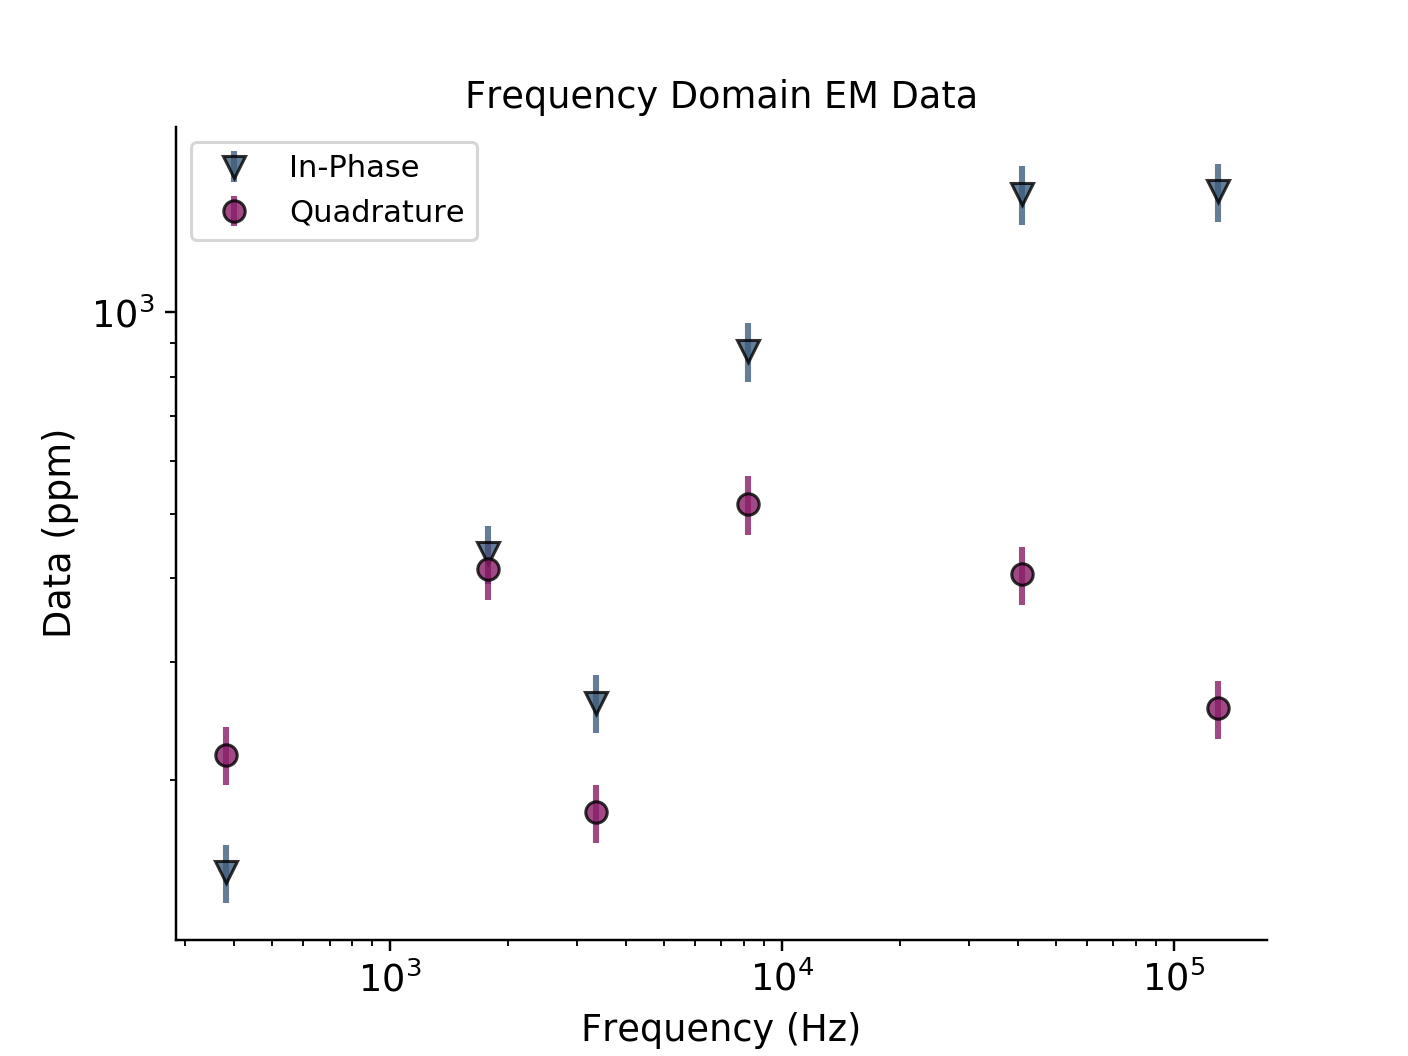

In [6]:
P = D.getDataPoint(0)
P.system[0].summary()
P.summary()
plt.figure()
P.plot()

## We can forward model the EM response of a 1D layered earth <a href="../Model/Model1D.ipynb">Model1D</a>

1D Model: 
Name:  # of Cells
    Units: 
    Shape: (1,)
   Values: [19]
No attached prior 
No attached proposal 
Top of the model: [0.]
Name:  Thickness
    Units: m
    Shape: (19,)
   Values: [10. 10. 10. ... 10. 10. inf]
No attached prior 
No attached proposal 
Name:  Conductivity
    Units: $\frac{S}{m}$
    Shape: (19,)
   Values: [0.01  0.015 0.02  ... 0.09  0.095 0.1  ]
No attached prior 
No attached proposal 
Name:  Depth
    Units: m
    Shape: (19,)
   Values: [ 10.  20.  30. ... 170. 180.  inf]
No attached prior 
No attached proposal 



<IPython.core.display.Javascript object>


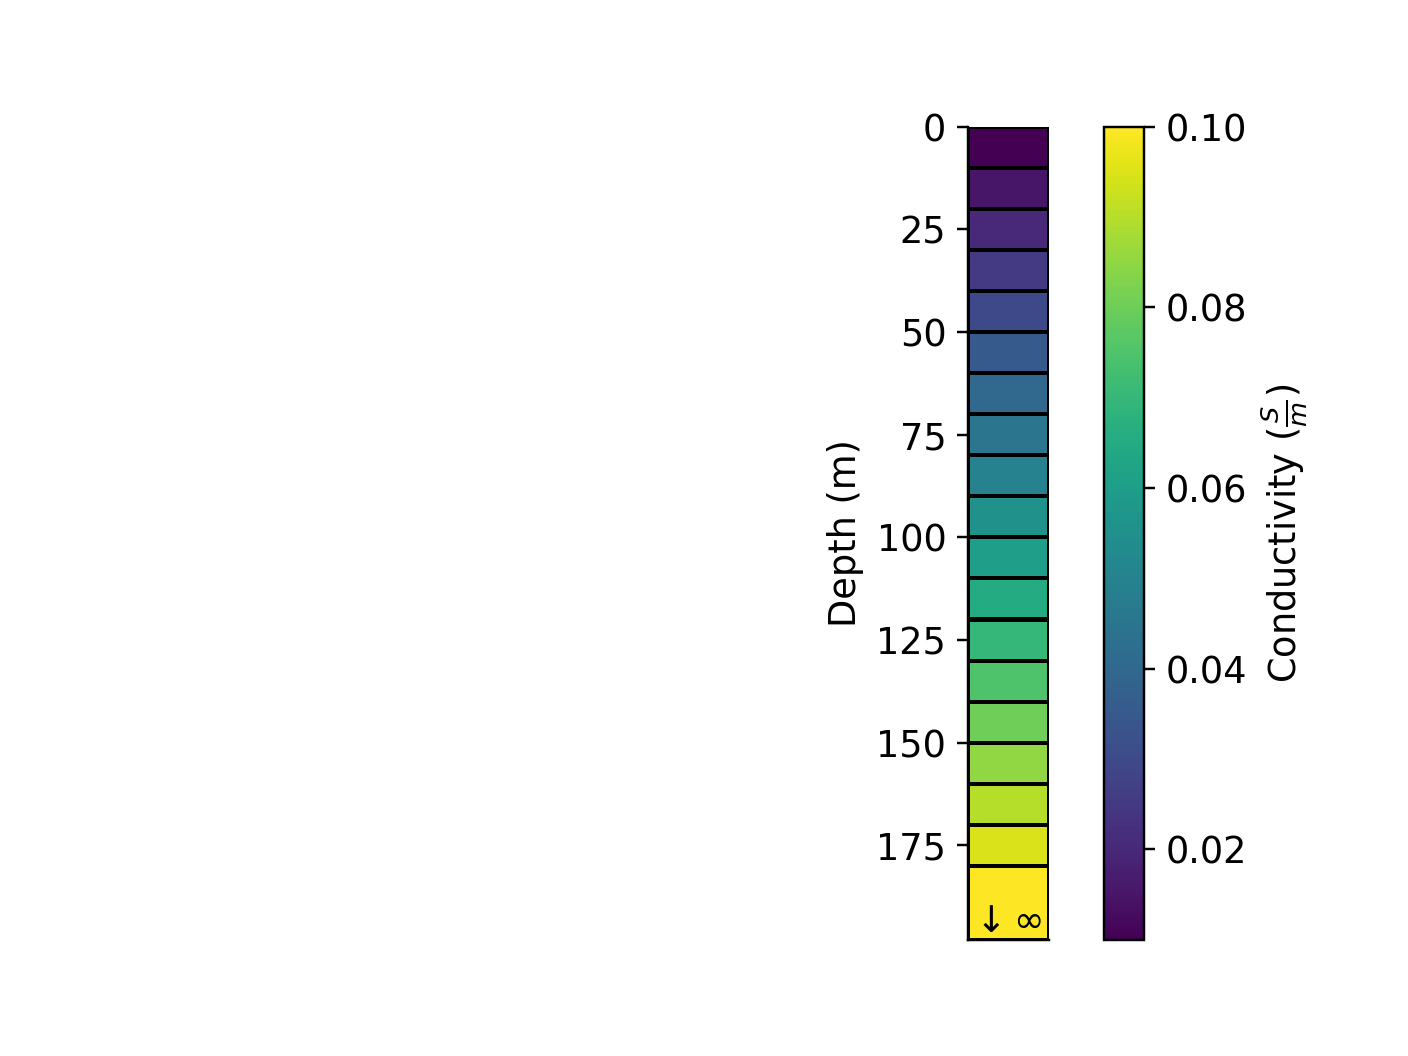

In [7]:
nCells = 19
par = StatArray(np.linspace(0.01, 0.1, nCells), "Conductivity", "$\frac{S}{m}$")
thk = StatArray(np.ones(nCells-1) * 10.0)
mod = Model1D(nCells = nCells, parameters=par, thickness=thk)
mod.summary()
plt.figure()
mod.pcolor(grid=True)

## Compute and plot the data from the model

In [8]:
%%time
P.forward(mod)

CPU times: user 1.78 ms, sys: 302 µs, total: 2.08 ms
Wall time: 2.1 ms


<IPython.core.display.Javascript object>


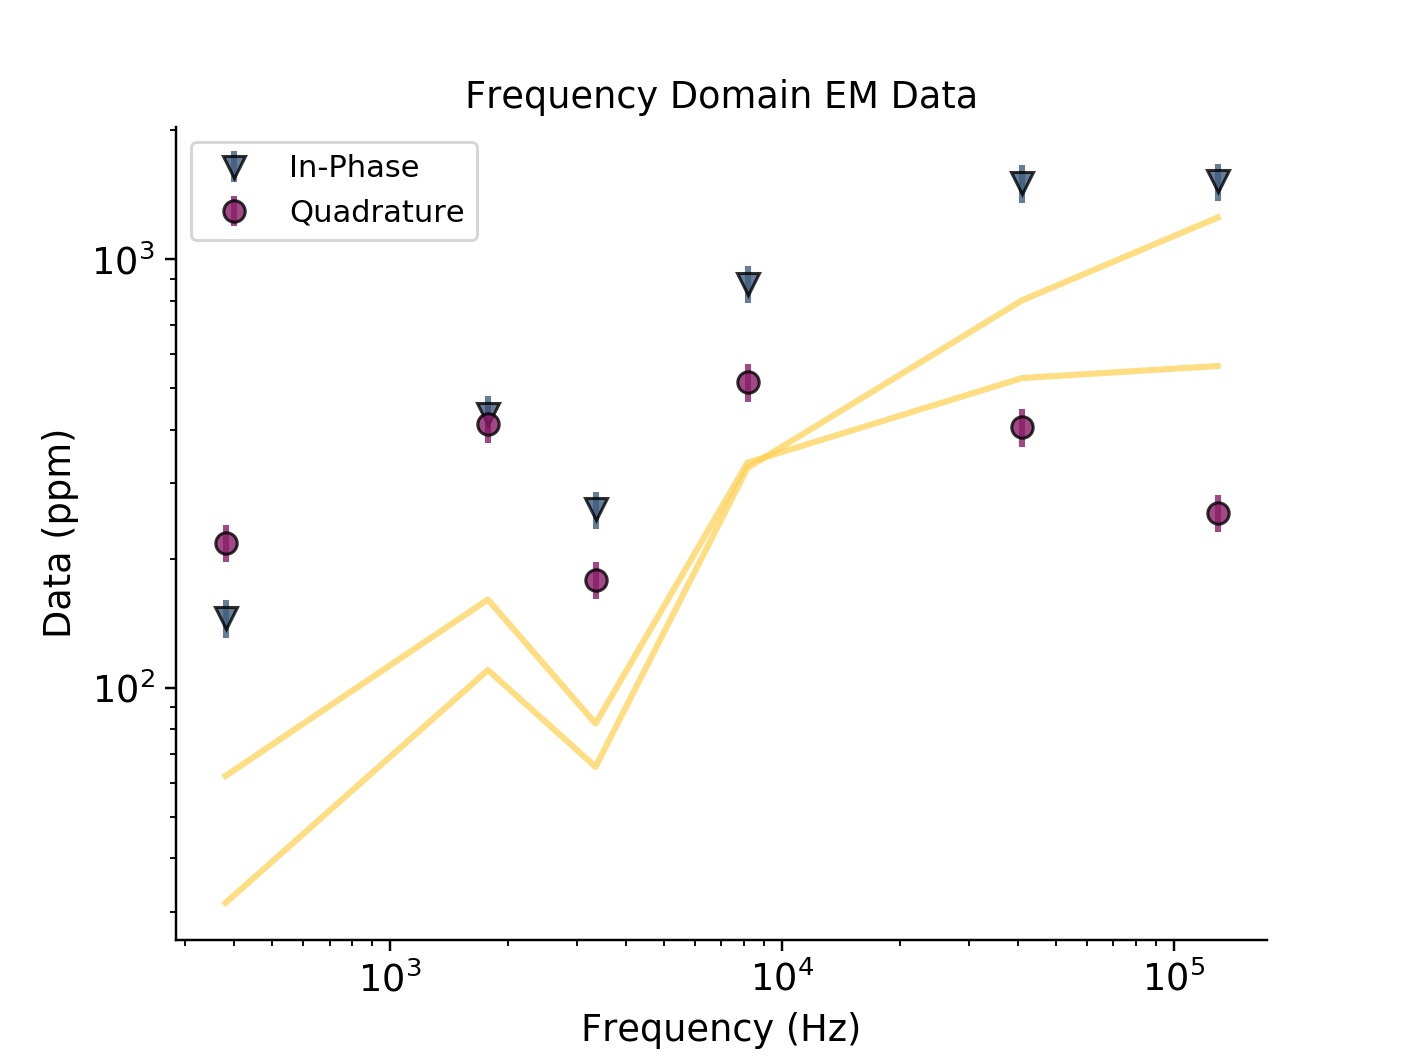

In [9]:
P.forward(mod)
plt.figure()
P.plot()
P.plotPredicted()

## The errors are set to zero right now, so lets change that

In [10]:
# Set the Prior
addErrors = StatArray(np.full(2*P.nFrequencies, 10.0))
P.predictedData.setPrior('MVNormalLog', addErrors, addErrors)
P.updateErrors(0.05, addErrors[:])

## With forward modelling, we can solve for the best fitting halfspace model

Best half space conductivity is  0.1036632928437698  $S/m$


<IPython.core.display.Javascript object>


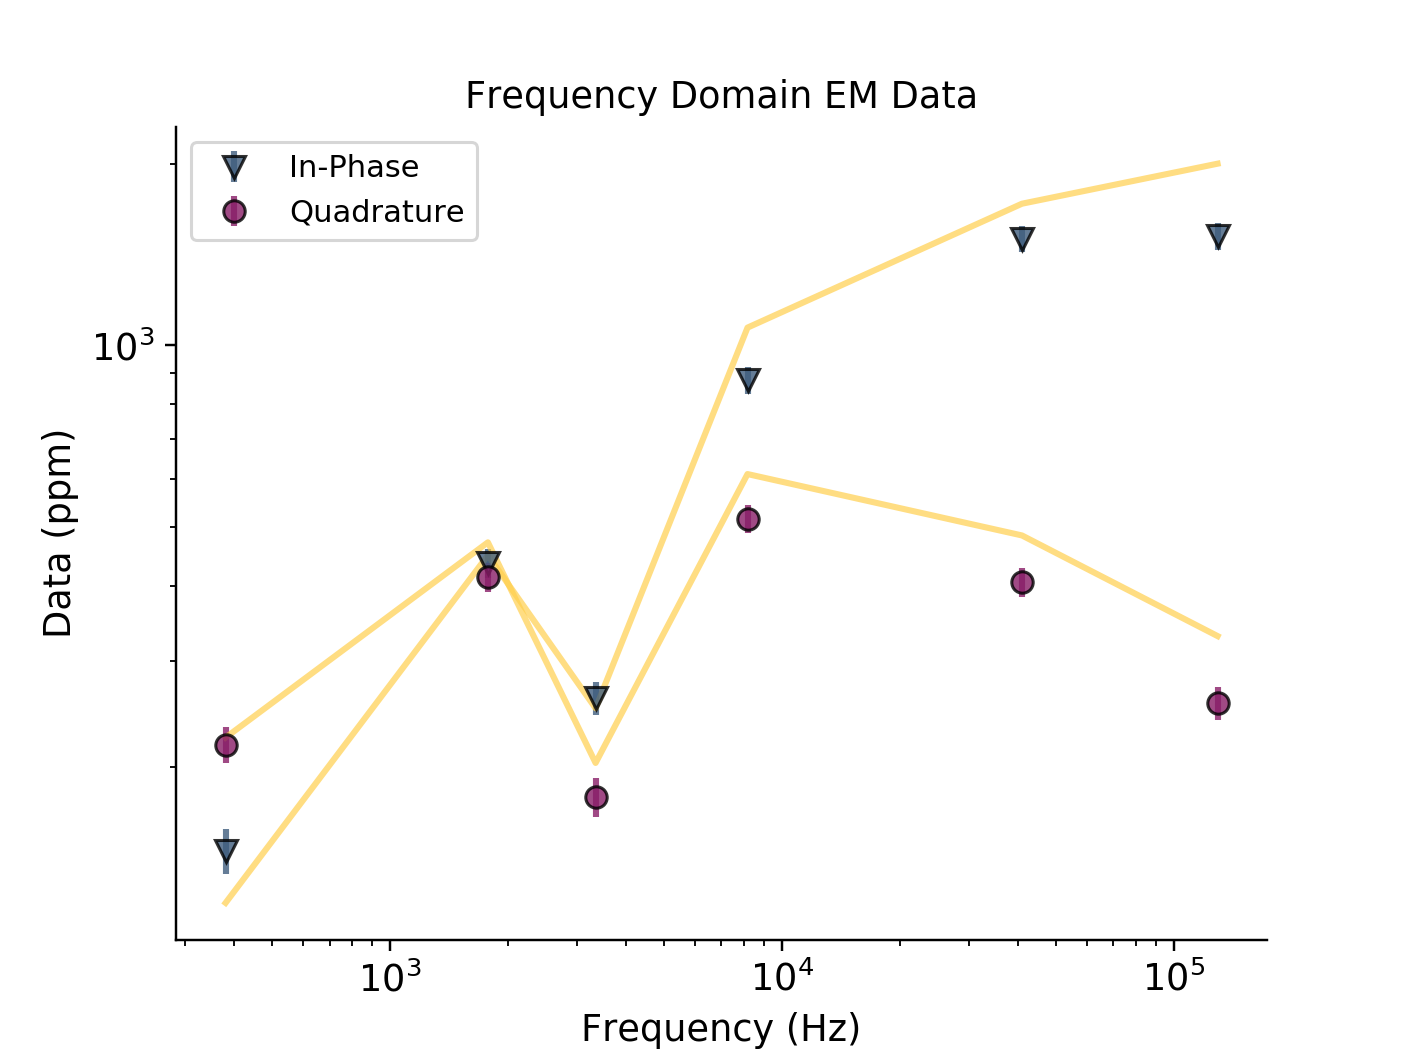

In [11]:
HSconductivity=P.FindBestHalfSpace()
print('Best half space conductivity is ', HSconductivity, ' $S/m$')
plt.figure()
P.plot()
P.plotPredicted()

## Compute the misfit between observed and predicted data

In [12]:
print(P.dataMisfit())

11.275909256512264


## Plot the misfits for a range of half space conductivities

<IPython.core.display.Javascript object>


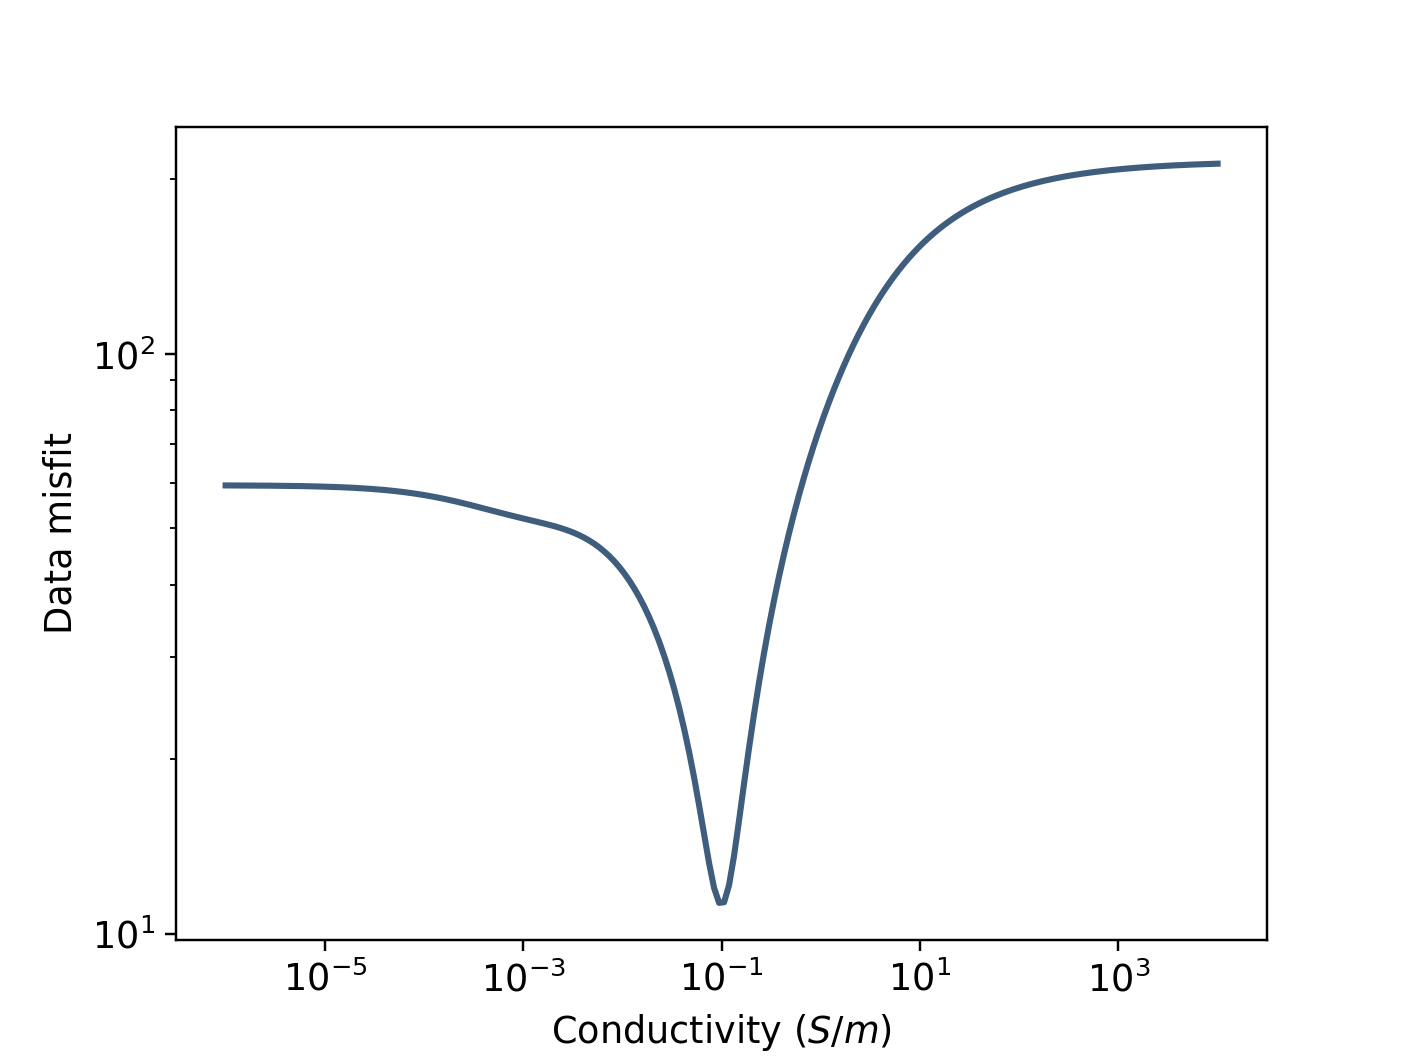

In [13]:
plt.figure()
P.plotHalfSpaceResponses(-6.0,4.0,200)

## Compute the sensitivity matrix for a given model

In [14]:
%%time
J = P.sensitivity(mod)

CPU times: user 13.4 ms, sys: 561 µs, total: 13.9 ms
Wall time: 13.9 ms


<IPython.core.display.Javascript object>


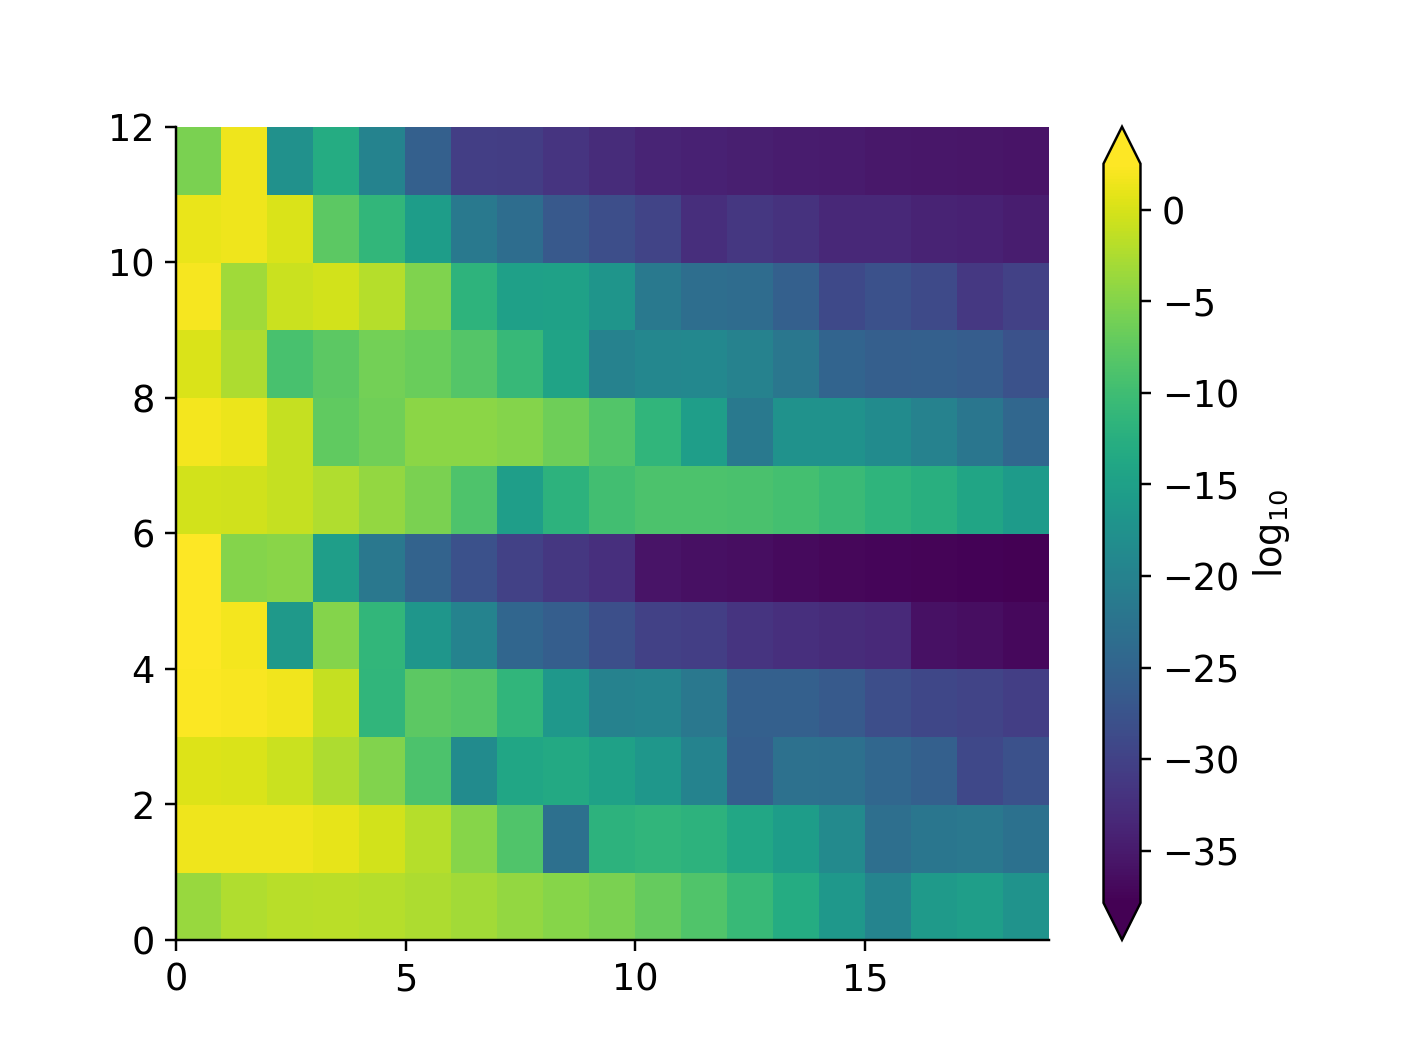

In [15]:
J = P.sensitivity(mod)
plt.figure()
np.abs(J).pcolor(equalize=True, log=10);

## We can save the FdemDataPoint to a HDF file

In [16]:
with h5py.File('FdemDataPoint.h5','w') as hf:
    P.createHdf(hf, 'fdp')
    P.writeHdf(hf, 'fdp')

## And then read it in

In [17]:
P1=hdfRead.readKeyFromFiles('FdemDataPoint.h5','/','fdp')